In [9]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# load data
all_input_weeks = []

for week in range(1, 19):  # Changed to 19 to include week 18
    input_df = pd.read_csv(f'../data/train/input_2023_w{week:02d}.csv') 
    input_df['week'] = week
    all_input_weeks.append(input_df)
    print(f"Loaded input week {week}")
input_df = pd.concat(all_input_weeks, ignore_index=True)  
print(f"\nTotal input rows: {len(input_df)}")

all_output_weeks = []

for week in range(1, 19):  # Changed to 19 to include week 18
    output_df = pd.read_csv(f'../data/train/output_2023_w{week:02d}.csv') 
    output_df['week'] = week
    all_output_weeks.append(output_df)
    print(f"Loaded output week {week}")
output_df = pd.concat(all_output_weeks, ignore_index=True)
print(f"\nTotal output rows: {len(output_df)}")

supplementary_df = pd.read_csv('../data/supplementary_data.csv')
print(f"Total plays in supplementary: {len(supplementary_df)}")

Loaded input week 1
Loaded input week 2
Loaded input week 3
Loaded input week 4
Loaded input week 5
Loaded input week 6
Loaded input week 7
Loaded input week 8
Loaded input week 9
Loaded input week 10
Loaded input week 11
Loaded input week 12
Loaded input week 13
Loaded input week 14
Loaded input week 15
Loaded input week 16
Loaded input week 17
Loaded input week 18

Total input rows: 4880579
Loaded output week 1
Loaded output week 2
Loaded output week 3
Loaded output week 4
Loaded output week 5
Loaded output week 6
Loaded output week 7
Loaded output week 8
Loaded output week 9
Loaded output week 10
Loaded output week 11
Loaded output week 12
Loaded output week 13
Loaded output week 14
Loaded output week 15
Loaded output week 16
Loaded output week 17
Loaded output week 18

Total output rows: 562936
Total plays in supplementary: 18009


/var/folders/0v/7v6b_kx92wn32v08jvcl87_h0000gn/T/ipykernel_71248/3475021708.py:22: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_df = pd.read_csv('../data/supplementary_data.csv')


In [20]:
# filter completions and man coverage
print(f"Before filtering: {len(supplementary_df)} plays")

supplementary_df = supplementary_df[supplementary_df['pass_result']=='C']
print(f"After completions filter: {len(supplementary_df)} plays")

supplementary_df = supplementary_df[supplementary_df['team_coverage_man_zone']=='MAN_COVERAGE']
print(f"After man coverage filter: {len(supplementary_df)} plays")

Before filtering: 3161 plays
After completions filter: 3161 plays
After man coverage filter: 3161 plays


In [24]:
# Filter to frame 1 and prepare data
print("Filtering to frame 1...")
output_df = output_df[output_df['frame_id'] == 1].copy()
input_df = input_df[input_df['frame_id'] == 1].copy()
print(f"Input frame 1: {len(input_df)} rows")
print(f"Output frame 1: {len(output_df)} rows")

# filter to only wrs and cbs
print("\nFiltering to CBs and WRs...")
input_df = input_df[(input_df['player_position']=='WR') | (input_df['player_position']=='CB')]
print(f"After CB/WR filter: {len(input_df)} rows")

# merge dataframes
print("\nMerging dataframes...")
merged_df = input_df.merge(output_df, how='inner', on=['game_id', 'play_id', 'nfl_id'], suffixes=('_input', '_output'))
print(f"After input-output merge: {len(merged_df)} rows")

merged_df = merged_df.merge(supplementary_df, how='inner', on=['game_id', 'play_id'])
print(f"After supplementary merge: {len(merged_df)} rows")

# Validation
print("\n=== MERGED DATA VALIDATION ===")
print(f"Player positions: {merged_df['player_position'].value_counts()}")
print(f"\nUnique plays: {merged_df[['game_id', 'play_id']].drop_duplicates().shape[0]}")
print(f"\nNull counts in key columns:")
print(merged_df[['x_output', 'y_output', 'player_position', 'ball_land_x', 'ball_land_y']].isna().sum())

print("\nFirst few rows:")
print(merged_df[['game_id', 'play_id', 'nfl_id', 'player_name', 'player_position', 'x_output', 'y_output']].head())

Filtering to frame 1...
Input frame 1: 75563 rows
Output frame 1: 46045 rows

Filtering to CBs and WRs...
After CB/WR filter: 75563 rows

Merging dataframes...
After input-output merge: 21886 rows
After supplementary merge: 4232 rows

=== MERGED DATA VALIDATION ===
Player positions: player_position
CB    2637
WR    1595
Name: count, dtype: int64

Unique plays: 2087

Null counts in key columns:
x_output           0
y_output           0
player_position    0
ball_land_x        0
ball_land_y        0
dtype: int64

First few rows:
      game_id  play_id  nfl_id        player_name player_position  x_output  \
0  2023090700      194   53953       Jerry Jacobs              CB     76.70   
1  2023090700      436   53541  Amon-Ra St. Brown              WR     33.98   
2  2023090700      621   52546     L'Jarius Sneed              CB    105.06   
3  2023090700      621   53541  Amon-Ra St. Brown              WR    103.05   
4  2023090700      736   44906     Cameron Sutton              CB     76.

## Section 8: Pair CBs with WRs

In [27]:
def pair_cbs_wrs_for_play(play_df, y_weight=2.0, x_weight=1.0):
    """
    Pair CBs and WRs for ONE play using weighted distance.
    Prioritizes lateral (y) alignment over depth (x).
    
    Parameters:
    -----------
    play_df : pandas DataFrame
        All players (CBs and WRs) on one play
    y_weight : float
        Weight for y-distance (default: 2.0)
    x_weight : float
        Weight for x-distance (default: 1.0)
    
    Returns:
    --------
    list : List of dictionaries, one per CB-WR pairing
    """
    
    # Separate CBs and WRs
    cbs = play_df[play_df['player_position'] == 'CB'].copy()
    wrs = play_df[play_df['player_position'] == 'WR'].copy()
    
    # Check if we have both
    if len(cbs) == 0 or len(wrs) == 0:
        return []
    
    # Get coordinates
    cb_y = cbs['y_output'].values  # Shape: (num_cbs,)
    wr_y = wrs['y_output'].values  # Shape: (num_wrs,)
    cb_x = cbs['x_output'].values
    wr_x = wrs['x_output'].values
    
    # Calculate pairwise distances using broadcasting
    # cb_y[:, None] reshapes to (num_cbs, 1)
    # Broadcasts to (num_cbs, num_wrs)
    y_diff = np.abs(cb_y[:, None] - wr_y)  # Shape: (num_cbs, num_wrs)
    x_diff = np.abs(cb_x[:, None] - wr_x)
    
    # Weighted distance (prioritize lateral alignment)
    weighted_dist = y_weight * y_diff + x_weight * x_diff  # Shape: (num_cbs, num_wrs)
    
    # For each WR (column), find closest CB (minimum in that column)
    closest_cb_indices = np.argmin(weighted_dist, axis=0)  # Shape: (num_wrs,)
    
    # Now create pairings
    pairings = []
    for wr_idx, cb_idx in enumerate(closest_cb_indices):
        wr_row = wrs.iloc[wr_idx]
        cb_row = cbs.iloc[cb_idx]
        
        # Calculate Euclidean cushion (actual distance)
        cushion = np.sqrt(
            (wr_row['x_output'] - cb_row['x_output'])**2 + 
            (wr_row['y_output'] - cb_row['y_output'])**2
        )
        
        pairing = {
            'game_id': wr_row['game_id'],
            'play_id': wr_row['play_id'],
            'week': wr_row['week_output'],
            'wr_nfl_id': wr_row['nfl_id'],
            'cb_nfl_id': cb_row['nfl_id'],
            'wr_name': wr_row['player_name'],
            'cb_name': cb_row['player_name'],
            'wr_x': wr_row['x_output'],
            'wr_y': wr_row['y_output'],
            'cb_x': cb_row['x_output'],
            'cb_y': cb_row['y_output'],
            'initial_cushion': cushion,
            'ball_land_x': wr_row['ball_land_x'],
            'ball_land_y': wr_row['ball_land_y']
        }
        
        pairings.append(pairing)
    
    return pairings

print("✓ Pairing function defined")

✓ Pairing function defined


## Testing: Single Play Validation

In [30]:
# Test with one simple play
test_game_id = 2023090700
test_play_id = 621

test_play_df = merged_df[
    (merged_df['game_id'] == test_game_id) & 
    (merged_df['play_id'] == test_play_id)
].copy()

print(f"Test play {test_game_id}-{test_play_id}:")
print(f"  Total players: {len(test_play_df)}")
print(f"  CBs: {len(test_play_df[test_play_df['player_position'] == 'CB'])}")
print(f"  WRs: {len(test_play_df[test_play_df['player_position'] == 'WR'])}")

# Run pairing
test_pairings = pair_cbs_wrs_for_play(test_play_df)

print(f"\nPairings created: {len(test_pairings)}")

if len(test_pairings) > 0:
    print("\nPairing details:")
    for p in test_pairings:
        print(f"  WR: {p['wr_name']:20} at ({p['wr_x']:6.2f}, {p['wr_y']:6.2f})")
        print(f"  CB: {p['cb_name']:20} at ({p['cb_x']:6.2f}, {p['cb_y']:6.2f})")
        print(f"  Cushion: {p['initial_cushion']:.2f}y | "
              f"Y-dist: {abs(p['wr_y'] - p['cb_y']):.2f}y | "
              f"X-dist: {abs(p['wr_x'] - p['cb_x']):.2f}y")
        print()
else:
    print("⚠ WARNING: No pairings created!")

Test play 2023090700-621:
  Total players: 2
  CBs: 1
  WRs: 1

Pairings created: 1

Pairing details:
  WR: Amon-Ra St. Brown    at (103.05,  23.59)
  CB: L'Jarius Sneed       at (105.06,  23.86)
  Cushion: 2.03y | Y-dist: 0.27y | X-dist: 2.01y



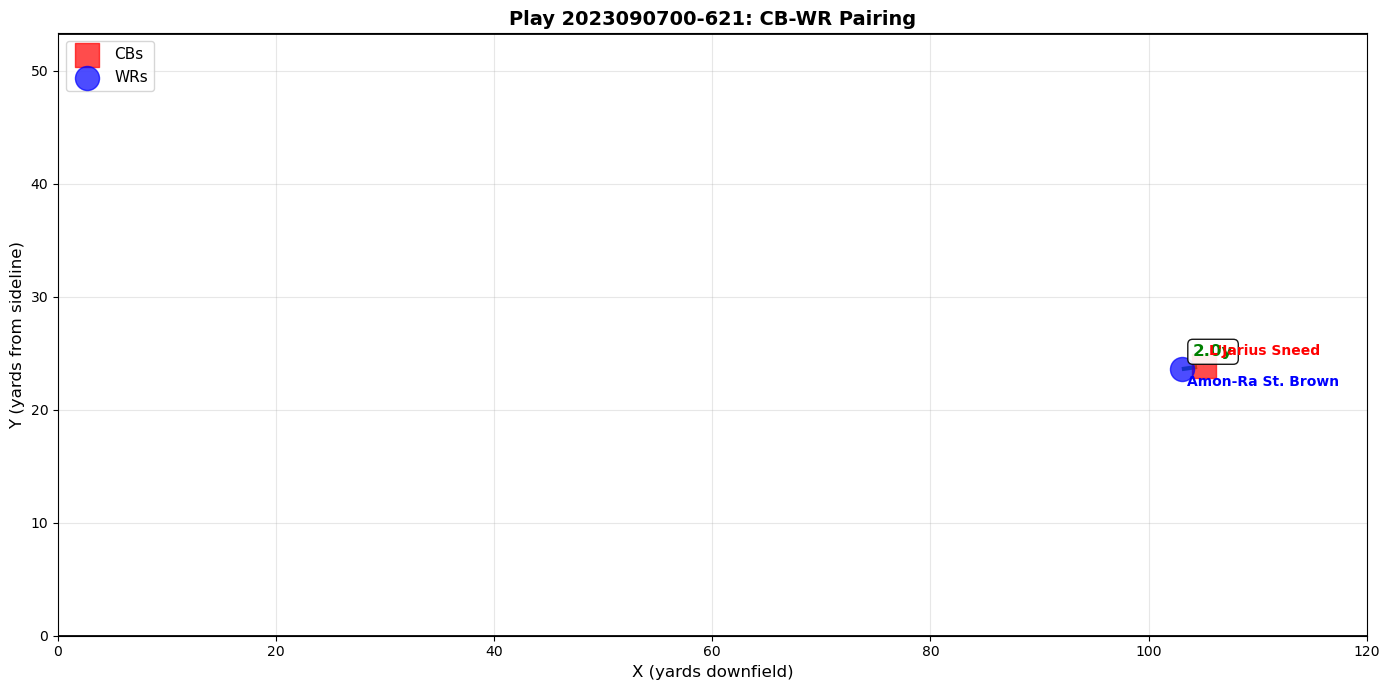

✓ Visualization complete


In [31]:
import os
# Visualize the test play
cbs = test_play_df[test_play_df['player_position'] == 'CB']
wrs = test_play_df[test_play_df['player_position'] == 'WR']

fig, ax = plt.subplots(figsize=(14, 7))

# Plot players
ax.scatter(cbs['x_output'], cbs['y_output'], 
           c='red', s=300, marker='s', label='CBs', alpha=0.7, zorder=3)
ax.scatter(wrs['x_output'], wrs['y_output'], 
           c='blue', s=300, marker='o', label='WRs', alpha=0.7, zorder=3)

# Draw pairing lines
if len(test_pairings) > 0:
    for p in test_pairings:
        ax.plot([p['wr_x'], p['cb_x']], 
                [p['wr_y'], p['cb_y']], 
                'g--', linewidth=3, alpha=0.7, zorder=2)
        
        # Add cushion label
        mid_x = (p['wr_x'] + p['cb_x']) / 2
        mid_y = (p['wr_y'] + p['cb_y']) / 2
        ax.text(mid_x, mid_y + 1, f"{p['initial_cushion']:.1f}y", 
                fontsize=12, color='green', weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Add player names
for _, cb in cbs.iterrows():
    ax.text(cb['x_output'] + 0.5, cb['y_output'] + 1, 
            cb['player_name'], fontsize=10, color='red', weight='bold')

for _, wr in wrs.iterrows():
    ax.text(wr['x_output'] + 0.5, wr['y_output'] - 1.5, 
            wr['player_name'], fontsize=10, color='blue', weight='bold')

# Field setup
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax.axhline(y=53.3, color='black', linestyle='-', linewidth=2)
ax.set_xlabel('X (yards downfield)', fontsize=12)
ax.set_ylabel('Y (yards from sideline)', fontsize=12)
ax.set_title(f'Play {test_game_id}-{test_play_id}: CB-WR Pairing', fontsize=14, weight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('../visualizations', exist_ok=True)
plt.savefig('../visualizations/test_pairing.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization complete")

## Main Processing: Pair All Plays

In [32]:
# Create unique plays list
unique_plays = merged_df[['game_id', 'play_id']].drop_duplicates().reset_index(drop=True)

print(f"Total unique plays to process: {len(unique_plays)}")
print(f"\nStarting pairing process...")
print("This may take 2-5 minutes...\n")

Total unique plays to process: 2087

Starting pairing process...
This may take 2-5 minutes...



In [33]:
# Main processing loop
all_pairings = []

for idx, row in unique_plays.iterrows():
    game_id = row['game_id']
    play_id = row['play_id']
    
    # Filter to this play
    play_df = merged_df[
        (merged_df['game_id'] == game_id) & 
        (merged_df['play_id'] == play_id)
    ]
    
    # Get pairings for this play
    play_pairings = pair_cbs_wrs_for_play(play_df, y_weight=2.0, x_weight=1.0)
    
    # Add to master list
    all_pairings.extend(play_pairings)
    
    # Progress tracking
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(unique_plays)} plays... ({len(all_pairings)} pairings so far)")

print(f"\n✓ Pairing complete!")
print(f"Total pairings created: {len(all_pairings)}")

Processed 100/2087 plays... (74 pairings so far)
Processed 200/2087 plays... (138 pairings so far)
Processed 300/2087 plays... (214 pairings so far)
Processed 400/2087 plays... (287 pairings so far)
Processed 500/2087 plays... (355 pairings so far)
Processed 600/2087 plays... (421 pairings so far)
Processed 700/2087 plays... (480 pairings so far)
Processed 800/2087 plays... (550 pairings so far)
Processed 900/2087 plays... (625 pairings so far)
Processed 1000/2087 plays... (693 pairings so far)
Processed 1100/2087 plays... (759 pairings so far)
Processed 1200/2087 plays... (831 pairings so far)
Processed 1300/2087 plays... (898 pairings so far)
Processed 1400/2087 plays... (968 pairings so far)
Processed 1500/2087 plays... (1039 pairings so far)
Processed 1600/2087 plays... (1107 pairings so far)
Processed 1700/2087 plays... (1178 pairings so far)
Processed 1800/2087 plays... (1247 pairings so far)
Processed 1900/2087 plays... (1308 pairings so far)
Processed 2000/2087 plays... (1376 p

In [34]:
# Convert to DataFrame
cushion_df = pd.DataFrame(all_pairings)

print(f"Cushion DataFrame shape: {cushion_df.shape}")
print(f"\nColumns:")
print(cushion_df.columns.tolist())
print(f"\nFirst few rows:")
print(cushion_df.head())

Cushion DataFrame shape: (1439, 14)

Columns:
['game_id', 'play_id', 'week', 'wr_nfl_id', 'cb_nfl_id', 'wr_name', 'cb_name', 'wr_x', 'wr_y', 'cb_x', 'cb_y', 'initial_cushion', 'ball_land_x', 'ball_land_y']

First few rows:
      game_id  play_id  week  wr_nfl_id  cb_nfl_id            wr_name  \
0  2023090700      621     1      53541      52546  Amon-Ra St. Brown   
1  2023090700      736     1      46213      44906      Justin Watson   
2  2023090700     1001     1      55920      53953        Rashee Rice   
3  2023090700     1869     1      44930      52546      Josh Reynolds   
4  2023090700     2613     1      53541      54486  Amon-Ra St. Brown   

          cb_name    wr_x   wr_y    cb_x   cb_y  initial_cushion  ball_land_x  \
0  L'Jarius Sneed  103.05  23.59  105.06  23.86         2.028053   102.919998   
1  Cameron Sutton   72.78  33.96   76.66  39.82         7.028087    68.470001   
2    Jerry Jacobs  117.71  34.98  115.48  27.03         8.256840   115.610001   
3  L'Jarius Sn

## Data Validation

In [35]:
print("="*60)
print("PAIRING VALIDATION REPORT")
print("="*60)

# Basic counts
print(f"\nTotal pairings: {len(cushion_df):,}")
print(f"Unique plays: {cushion_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"Unique WRs: {cushion_df['wr_nfl_id'].nunique()}")
print(f"Unique CBs: {cushion_df['cb_nfl_id'].nunique()}")

# Calculate component distances
cushion_df['y_dist'] = abs(cushion_df['wr_y'] - cushion_df['cb_y'])
cushion_df['x_dist'] = abs(cushion_df['wr_x'] - cushion_df['cb_x'])

# Cushion distribution
print("\n--- Initial Cushion Distance (yards) ---")
print(cushion_df['initial_cushion'].describe())

# Y-distance (MOST IMPORTANT - should be small)
print("\n--- Y-Distance / Lateral Alignment (yards) ---")
print("(Lower is better - indicates CBs aligned with WRs laterally)")
print(cushion_df['y_dist'].describe())

# X-distance 
print("\n--- X-Distance / Depth Separation (yards) ---")
print(cushion_df['x_dist'].describe())

# Check for problematic pairings
print("\n--- Potential Issues ---")
high_y = (cushion_df['y_dist'] > 10).sum()
high_cushion = (cushion_df['initial_cushion'] > 15).sum()

print(f"Pairings with y-dist > 10 yards: {high_y:,} ({high_y / len(cushion_df) * 100:.2f}%)")
print(f"Pairings with cushion > 15 yards: {high_cushion:,} ({high_cushion / len(cushion_df) * 100:.2f}%)")

if high_y / len(cushion_df) > 0.05:
    print("\n⚠ WARNING: >5% of pairings have large y-distance. Consider increasing y_weight.")
else:
    print("\n✓ Y-distance distribution looks good!")

# Show worst pairings
print("\n--- Worst Lateral Pairings (Highest Y-Distance) ---")
worst_y = cushion_df.nlargest(5, 'y_dist')[[
    'game_id', 'play_id', 'wr_name', 'cb_name', 
    'wr_y', 'cb_y', 'y_dist', 'initial_cushion'
]]
print(worst_y.to_string(index=False))

PAIRING VALIDATION REPORT

Total pairings: 1,439
Unique plays: 1,439
Unique WRs: 168
Unique CBs: 173

--- Initial Cushion Distance (yards) ---
count    1439.000000
mean        3.431372
std         2.598834
min         0.542033
25%         1.547999
50%         2.679048
75%         4.522239
max        20.750118
Name: initial_cushion, dtype: float64

--- Y-Distance / Lateral Alignment (yards) ---
(Lower is better - indicates CBs aligned with WRs laterally)
count    1439.000000
mean        1.920869
std         2.132562
min         0.000000
25%         0.790000
50%         1.330000
75%         2.215000
max        20.750000
Name: y_dist, dtype: float64

--- X-Distance / Depth Separation (yards) ---
count    1439.000000
mean        2.353933
std         2.179785
min         0.000000
25%         0.680000
50%         1.600000
75%         3.575000
max        12.430000
Name: x_dist, dtype: float64

--- Potential Issues ---
Pairings with y-dist > 10 yards: 22 (1.53%)
Pairings with cushion > 15 yard

## Save Results

In [36]:
# First, let's see what columns supplementary_df actually has
print("Available columns in supplementary_df:")
print([col for col in supplementary_df.columns if 'yard' in col.lower()])

# Merge with supplementary data to get route, EPA, etc.
print("\nMerging with play metadata...")

cushion_df = cushion_df.merge(
    supplementary_df[[
        'game_id', 'play_id', 
        'route_of_targeted_receiver',
        'expected_points_added',
        'yards_gained',
        'team_coverage_type',
        'down',
        'yards_to_go',
        'receiver_alignment'
        # Removed absolute_yardline_number for now - we'll add it back after seeing column names
    ]],
    on=['game_id', 'play_id'],
    how='left'
)

# Rename columns for clarity
cushion_df = cushion_df.rename(columns={
    'route_of_targeted_receiver': 'route',
    'expected_points_added': 'epa'
})

print(f"\nFinal DataFrame shape: {cushion_df.shape}")
print(f"\nColumns:")
print(cushion_df.columns.tolist())

Available columns in supplementary_df:
['yards_to_go', 'yardline_side', 'yardline_number', 'penalty_yards', 'pre_penalty_yards_gained', 'yards_gained']

Merging with play metadata...

Final DataFrame shape: (1439, 23)

Columns:
['game_id', 'play_id', 'week', 'wr_nfl_id', 'cb_nfl_id', 'wr_name', 'cb_name', 'wr_x', 'wr_y', 'cb_x', 'cb_y', 'initial_cushion', 'ball_land_x', 'ball_land_y', 'y_dist', 'x_dist', 'route', 'epa', 'yards_gained', 'team_coverage_type', 'down', 'yards_to_go', 'receiver_alignment']


In [37]:
# Save to CSV
output_path = '../data/processed/cushion_analysis_data.csv'

cushion_df.to_csv(output_path, index=False)

print(f"✓ Data saved to: {output_path}")
print(f"\nFile size: {cushion_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

✓ Data saved to: ../data/processed/cushion_analysis_data.csv

File size: 0.6 MB


## Summary Statistics

In [38]:
print("="*60)
print("DATA PREPARATION COMPLETE - SUMMARY")
print("="*60)

print(f"\nTotal CB-WR Pairings: {len(cushion_df):,}")
print(f"Unique Plays: {cushion_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"Weeks Covered: {cushion_df['week'].min()}-{cushion_df['week'].max()}")

print("\n--- Plays by Route ---")
route_counts = cushion_df['route'].value_counts().head(10)
for route, count in route_counts.items():
    print(f"  {route:15} {count:>4}")

print("\n--- Cushion Statistics (yards) ---")
print(f"  Mean:    {cushion_df['initial_cushion'].mean():>6.2f}")
print(f"  Median:  {cushion_df['initial_cushion'].median():>6.2f}")
print(f"  Std:     {cushion_df['initial_cushion'].std():>6.2f}")
print(f"  Min:     {cushion_df['initial_cushion'].min():>6.2f}")
print(f"  Max:     {cushion_df['initial_cushion'].max():>6.2f}")

print("\n--- EPA Statistics ---")
print(f"  Mean:    {cushion_df['epa'].mean():>6.2f}")
print(f"  Median:  {cushion_df['epa'].median():>6.2f}")
print(f"  Std:     {cushion_df['epa'].std():>6.2f}")

print("\n--- Y-Distance (Lateral Alignment) ---")
print(f"  Mean:    {cushion_df['y_dist'].mean():>6.2f}")
print(f"  Median:  {cushion_df['y_dist'].median():>6.2f}")
print(f"  90th %:  {cushion_df['y_dist'].quantile(0.9):>6.2f}")

print(f"\nData saved to: {output_path}")
print("="*60)
print("\n✓ Ready for analysis in notebook 02!")

DATA PREPARATION COMPLETE - SUMMARY

Total CB-WR Pairings: 1,439
Unique Plays: 1,439
Weeks Covered: 1-18

--- Plays by Route ---
  OUT              256
  HITCH            239
  SLANT            214
  CROSS            207
  GO               180
  IN               112
  POST              78
  CORNER            72
  FLAT              56
  SCREEN            18

--- Cushion Statistics (yards) ---
  Mean:      3.43
  Median:    2.68
  Std:       2.60
  Min:       0.54
  Max:      20.75

--- EPA Statistics ---
  Mean:      1.47
  Median:    1.40
  Std:       1.49

--- Y-Distance (Lateral Alignment) ---
  Mean:      1.92
  Median:    1.33
  90th %:    3.84

Data saved to: ../data/processed/cushion_analysis_data.csv

✓ Ready for analysis in notebook 02!
